In [2]:
import os
import cv2
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt

from skimage.color import rgb2gray
from skimage.morphology import binary_opening, binary_erosion, binary_dilation, binary_closing
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.filters import threshold_local, try_all_threshold, threshold_otsu, gaussian
from skimage.measure import regionprops
from skimage.measure import label as sk_measure_label

In [3]:
def get_largest_component(mask):
    labels = sk_measure_label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности
    
#     print("Значения площади для каждой компоненты связности: {}".format(areas))
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью

#     print("labels - матрица, заполненная индексами компонент связности со значениями из множества: {}".format(np.unique(labels)))
    return labels == (largest_comp_id + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу

In [4]:
def get_largest_component_by_num(mask, num):
    labels = sk_measure_label(mask) # компоненты связности
    props = regionprops(labels) # свойства каждой области
    areas = np.array([prop.area for prop in props]) # площади компонент связности
        
    areas_copy = areas.copy()
    sorted_indexes = np.array([])

    for i in range(areas.size):
        largest_comp_id = np.array(areas_copy).argmax() # номер компоненты с максимальной площадью
        sorted_indexes = np.append(sorted_indexes, largest_comp_id)
        areas_copy[largest_comp_id] = 0
        
#     print("Значения площади для каждой компоненты связности: {}".format(areas))
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью

#     print("labels - матрица, заполненная индексами компонент связности со значениями из множества: {}".format(np.unique(labels)))
    return labels == (sorted_indexes[num] + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу

In [5]:
def bradley_roth_threshold(image):
    img = np.array(image).astype(float)
    width = image.shape[1]
    height = image.shape[0]
    
    # Будем разбивать изображение на прямоугольники со стороной s
    s = np.round(width/8)
    s = s + np.mod(s,2) # если s - нечетное:
    
    # Среднее значение интенсивности в каждом прямоугольнике будем изменять на величину t(%)
    t = 15.0

    # Интегральное изображение
    integral_image = cv2.integral(image)
    
    # Строим сетку пикселей
    (X,Y) = np.meshgrid(np.arange(width), np.arange(height))
    X = X.ravel()
    Y = Y.ravel()

    # Получаем все координаты соседних фрагментов
    x1 = X - s/2
    x2 = X + s/2
    y1 = Y - s/2
    y2 = Y + s/2

    # Поправляем координаты, вышедшие за границы изображения
    x1[x1 < 0] = 0
    x2[x2 >= width] = width - 1
    y1[y1 < 0] = 0
    y2[y2 >= height] = height - 1

    x1 = x1.astype(int)
    x2 = x2.astype(int)
    y1 = y1.astype(int)
    y2 = y2.astype(int)

    # Находим количество пикселей в каждой области
    count = (x2 - x1) * (y2 - y1)

    # Правый нижний фрагмент
    f1_x = x2
    f1_y = y2
    
    # Правый верхний
    f2_x = x2
    f2_y = y1 - 1
    f2_y[f2_y < 0] = 0 # если вышли за границу изображения
    
    # Левый нижний
    f3_x = x1-1
    f3_x[f3_x < 0] = 0 # если вышли за границу изображения
    f3_y = y2
    
    # Левый верхний
    f4_x = f3_x
    f4_y = f2_y

    # Вычисляем сумму значений яркостей по областям
    sums = integral_image[f1_y, f1_x] - integral_image[f2_y, f2_x] - integral_image[f3_y, f3_x] + integral_image[f4_y, f4_x]

    res = np.ones(height * width, dtype=bool)
    res[img.ravel() * count <= sums * (100.0 - t)/100.0] = False

    res = 255 * np.reshape(res, (height, width)).astype(np.uint8)

    return res

## Получим маски для шаблонных изображений

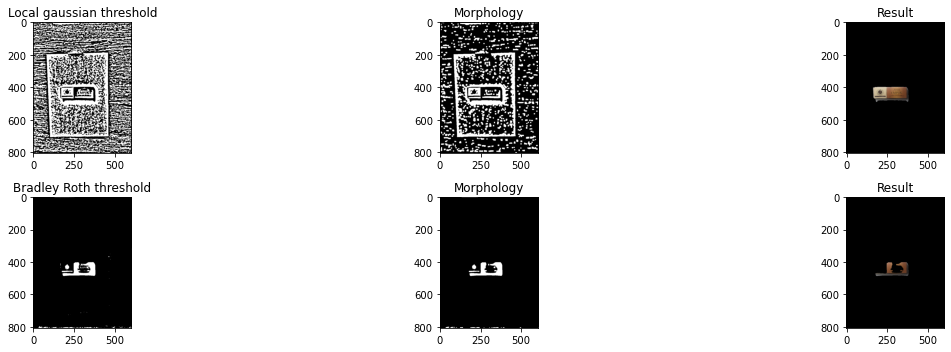

In [36]:
image_path = os.path.join('input\objects', '1_1.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)

fig, ax = plt.subplots(2, 3, figsize=(20, 5))

# Используем локальное пороговое значение, полученное с помощью фильтра Гаусса
background_threshold = threshold_local(gray_image, 37, method='gaussian')
threshold_res = gray_image >= background_threshold
ax[0, 0].imshow(threshold_res, cmap="gray")

threshold_res_enclosed_inside = binary_erosion(binary_dilation(threshold_res))
threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
ax[0, 1].imshow(threshold_res_enclosed, cmap="gray")

# Используя модифицированную функцию, выбираем вторую по площади компоненту вокруг объекта
result_mask = get_largest_component_by_num(1 - get_largest_component_by_num(threshold_res_enclosed, 1), 1)
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[0, 2].imshow(result, cmap="gray")


# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[1, 0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1, 1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[1, 2].imshow(result, cmap='gray')

for i, title in enumerate(["Local gaussian threshold", "Morphology", "Result"]):
    ax[0, i].set_title(title)
    
for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[1, i].set_title(title)
    
fig.tight_layout()

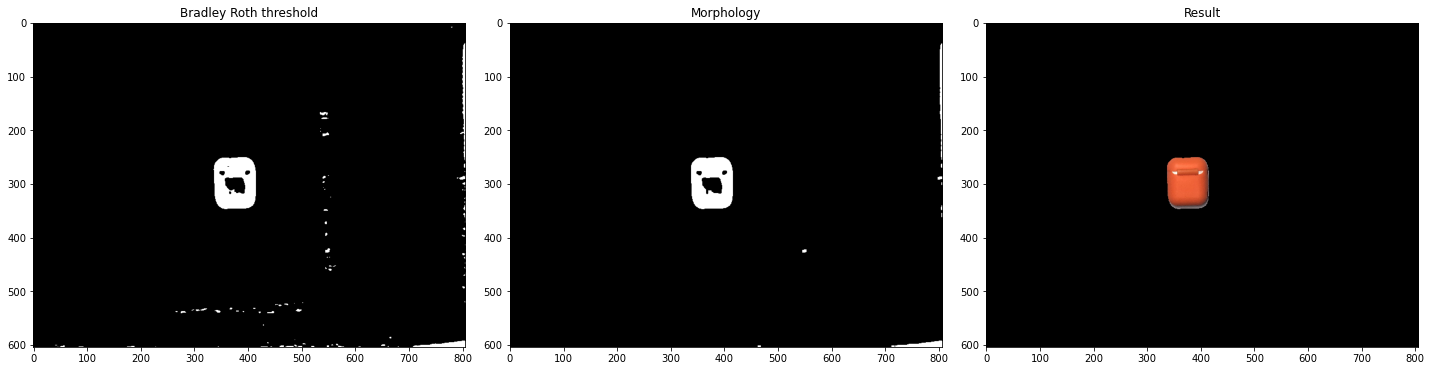

In [166]:
image_path = os.path.join('input\objects', '2.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

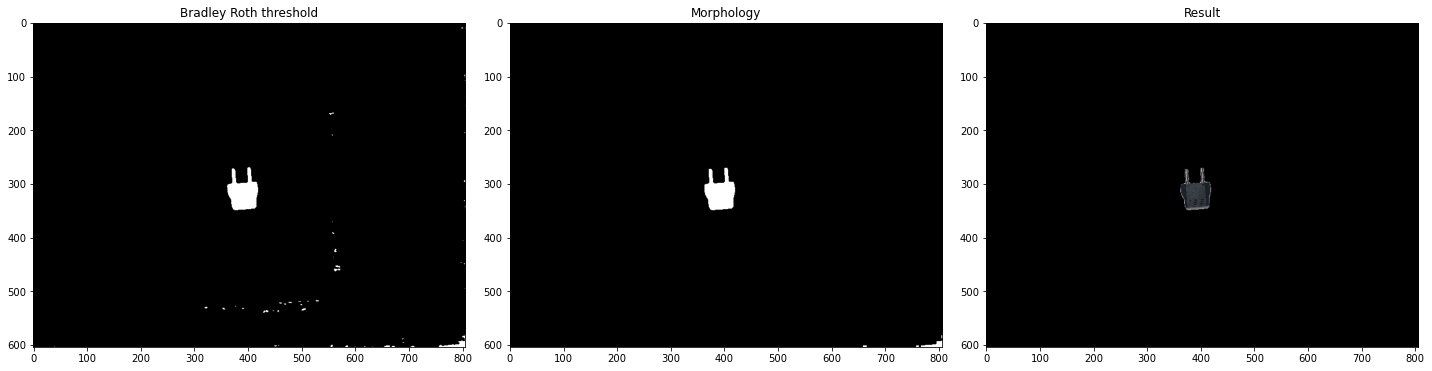

In [165]:
image_path = os.path.join('input\objects', '3.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

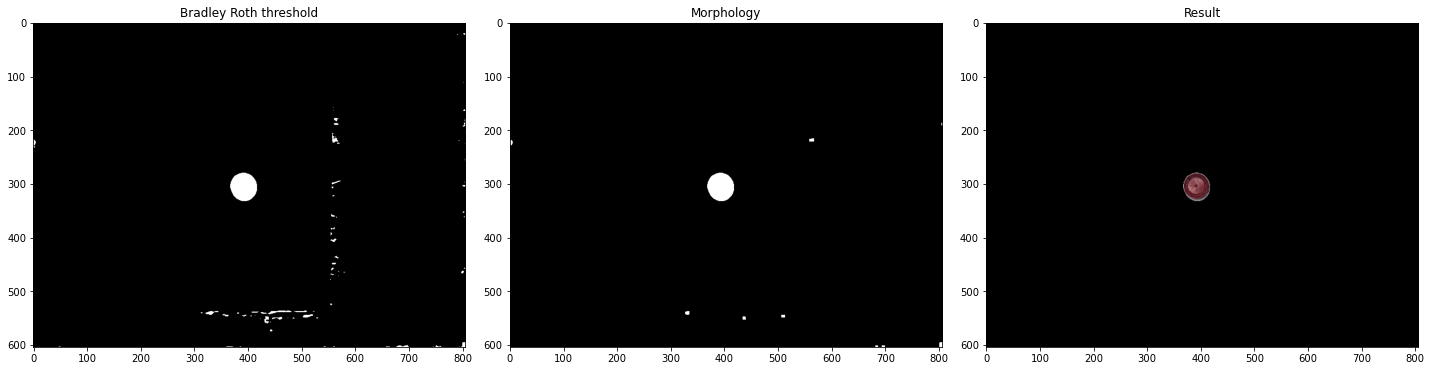

In [167]:
image_path = os.path.join('input\objects', '4.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

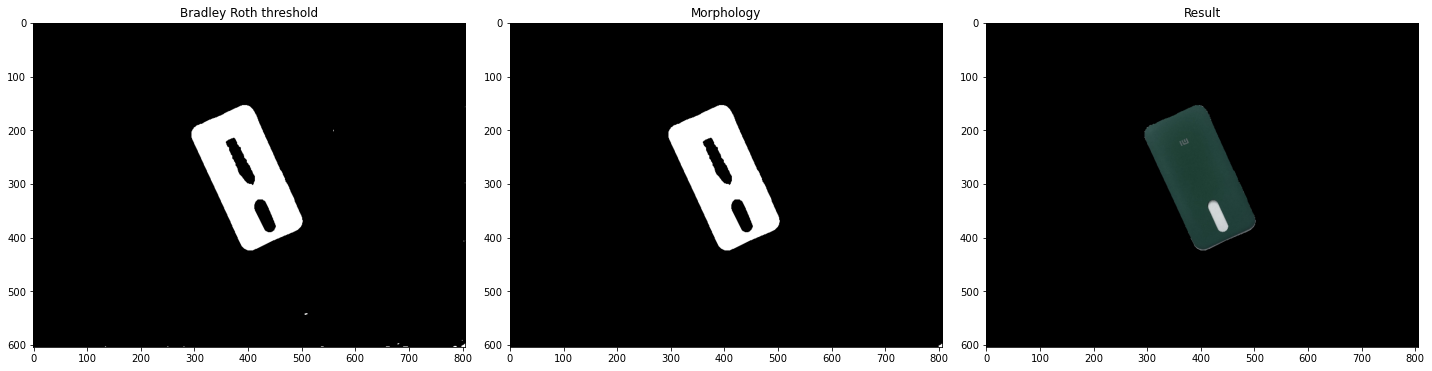

In [168]:
image_path = os.path.join('input\objects', '5.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

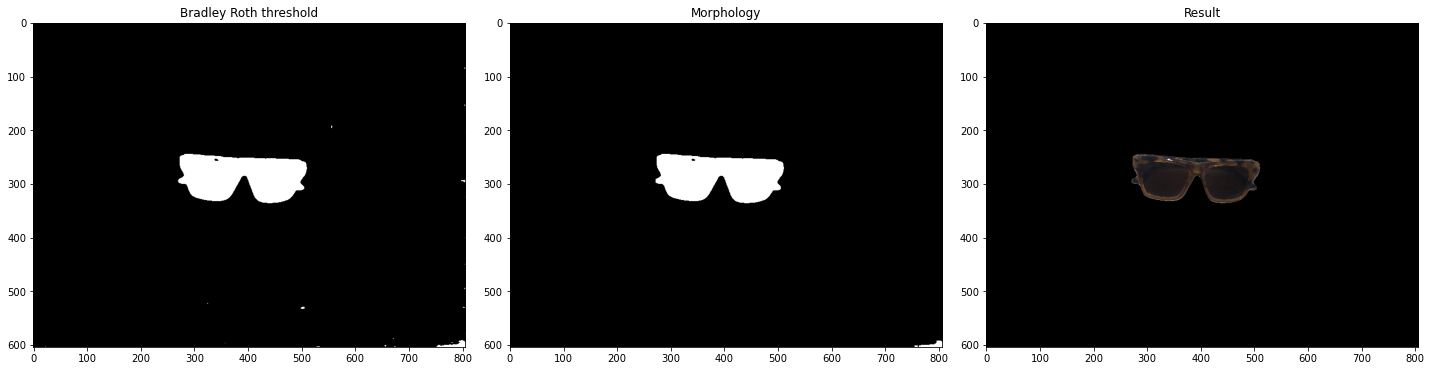

In [169]:
image_path = os.path.join('input\objects', '6.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

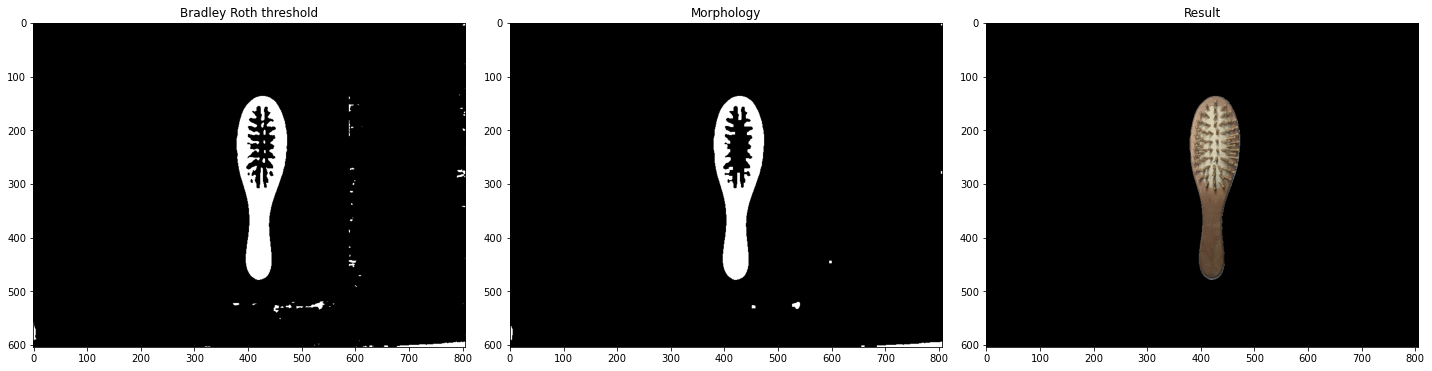

In [170]:
image_path = os.path.join('input\objects', '7.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

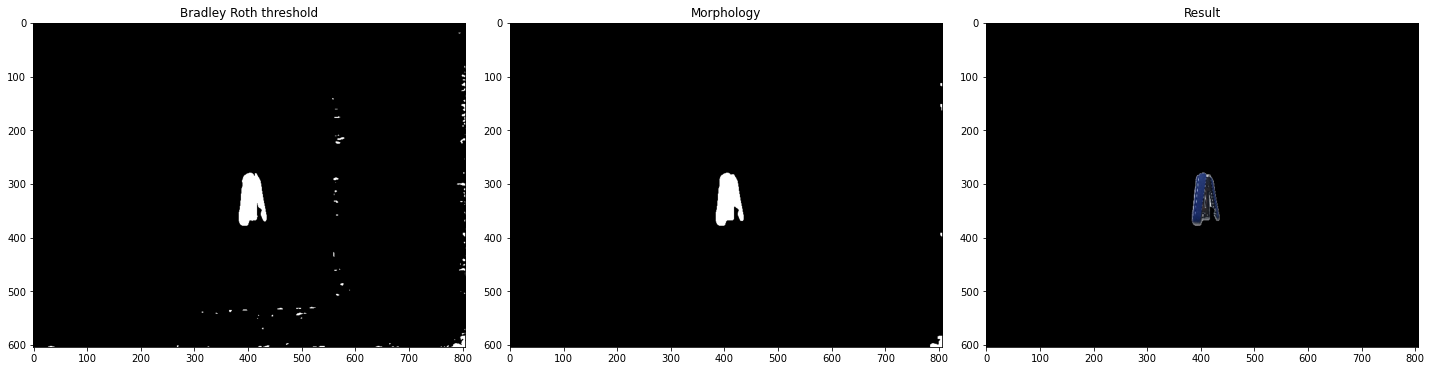

In [171]:
image_path = os.path.join('input\objects', '8.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

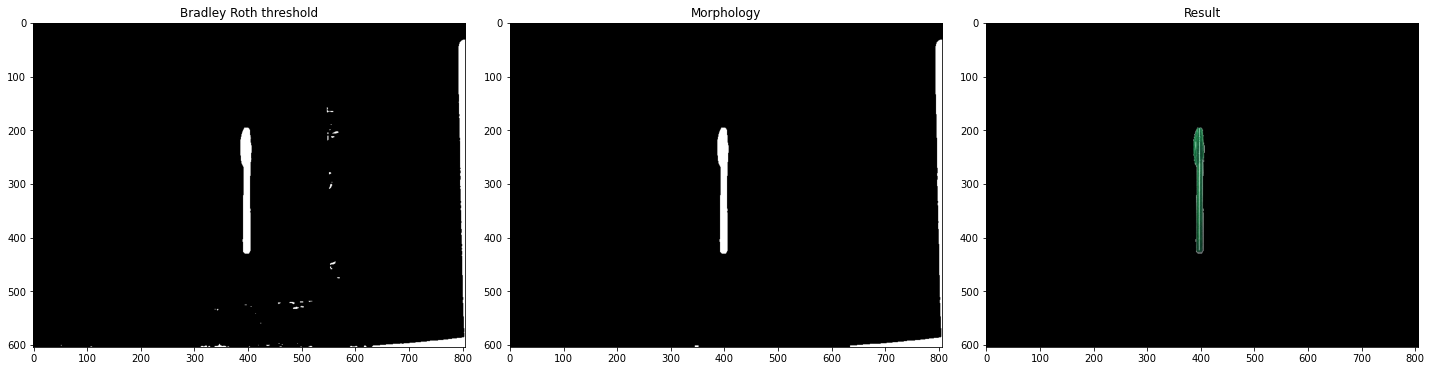

In [192]:
image_path = os.path.join('input\objects', '9.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

# убираем лишнее вне предмета, ручка - вторая по величине компонента, используем модифицированную функцию
object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 1)
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

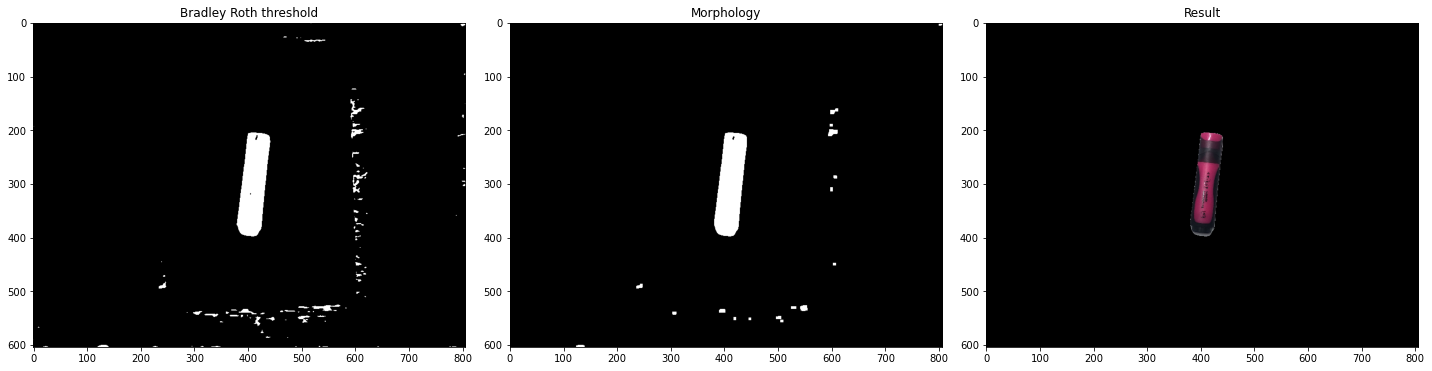

In [260]:
image_path = os.path.join('input\objects', '10.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

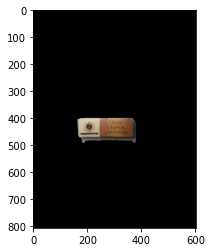

In [37]:
image_path = os.path.join('input\objects', '1_1.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)

# Используем локальное пороговое значение, полученное с помощью фильтра Гаусса
background_threshold = threshold_local(gray_image, 37, method='gaussian')
threshold_res = gray_image >= background_threshold

threshold_res_enclosed_inside = binary_erosion(binary_dilation(threshold_res))
threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))

# Используя модифицированную функцию, выбираем вторую по площади компоненту вокруг объекта
result_mask = get_largest_component_by_num(1 - get_largest_component_by_num(threshold_res_enclosed, 1), 1)
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
plt.imshow(result, cmap='gray')

# # Используем алгоритм определения порога Брэдли-Рота
# bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))

# bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
# bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))

# object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
# inverted_object_mask =  1 - object_mask
# result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
# result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
# plt.imshow(result, cmap='gray')
    
fig.tight_layout()

# Сохранение полученного изображения в файл
binarization_result = os.path.join("input\objects\masks", "1_1_mask.png")
plt.savefig(binarization_result)

## Получим маски для поверхности, чтобы далее отделять предметы и многоугольник

<class 'imageio.core.util.Array'>


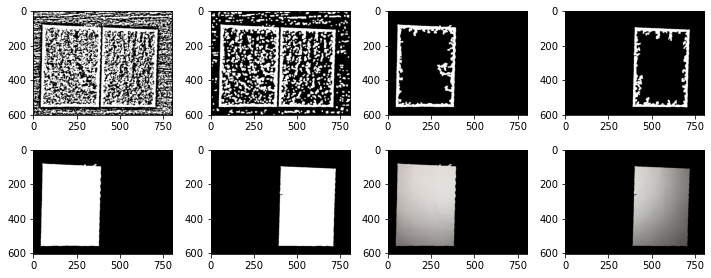

In [25]:
background_path = os.path.join('input\\tests', 'background.jpeg')
background = imread(background_path)
print(type(background))

compressed_background = cv2.resize(background, [int(background.shape[1] * 0.2), int(background.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_background = gaussian(compressed_background, sigma=1.5, channel_axis=2)
gray_background = rgb2gray(filtered_background)

fig, ax = plt.subplots(2, 4, figsize=(10, 4))

background_threshold = threshold_local(gray_background, 47, method='gaussian')
threshold_res = gray_background >= background_threshold
ax[0, 0].imshow(threshold_res, cmap="gray")

threshold_res_enclosed_inside = binary_erosion(binary_dilation(threshold_res))
threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
ax[0, 1].imshow(threshold_res_enclosed, cmap="gray")

# Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
component_of_left_sheet = get_largest_component_by_num(threshold_res_enclosed, 0)
component_of_right_sheet = get_largest_component_by_num(threshold_res_enclosed, 1)
ax[0, 2].imshow(component_of_left_sheet, cmap="gray")
ax[0, 3].imshow(component_of_right_sheet, cmap="gray")

left_sheet_mask = 1 - get_largest_component(1 - component_of_left_sheet)
right_sheet_mask = 1 - get_largest_component(1 - component_of_right_sheet)

ax[1, 0].imshow(left_sheet_mask, cmap="gray")
ax[1, 1].imshow(right_sheet_mask, cmap="gray")

left_sheet_mask = left_sheet_mask.astype("uint8")
right_sheet_mask = right_sheet_mask.astype("uint8")
ax[1, 2].imshow(cv2.bitwise_and(compressed_background,compressed_background,mask = left_sheet_mask), cmap="gray")
ax[1, 3].imshow(cv2.bitwise_and(compressed_background,compressed_background,mask = right_sheet_mask), cmap="gray")

fig.tight_layout()

Используя полученный для изображения с пустыми листами алгоритм, разделим тестовые изображения на два, соответствующих левому и правому листу. Так как для выделения компонент листов используется метод get_largest_component_by_num(), результат работы которого зависит от ракурса изображения, полученные маски не обязательно будут соответствовать листам в порядке слева направо. Следовательно, для правильного разделения на лист с предметами и лист с многоугольником сравним интенсивности пикселей изображений, полученных в результате применения масок.

IndexError: index 3 is out of bounds for axis 1 with size 3

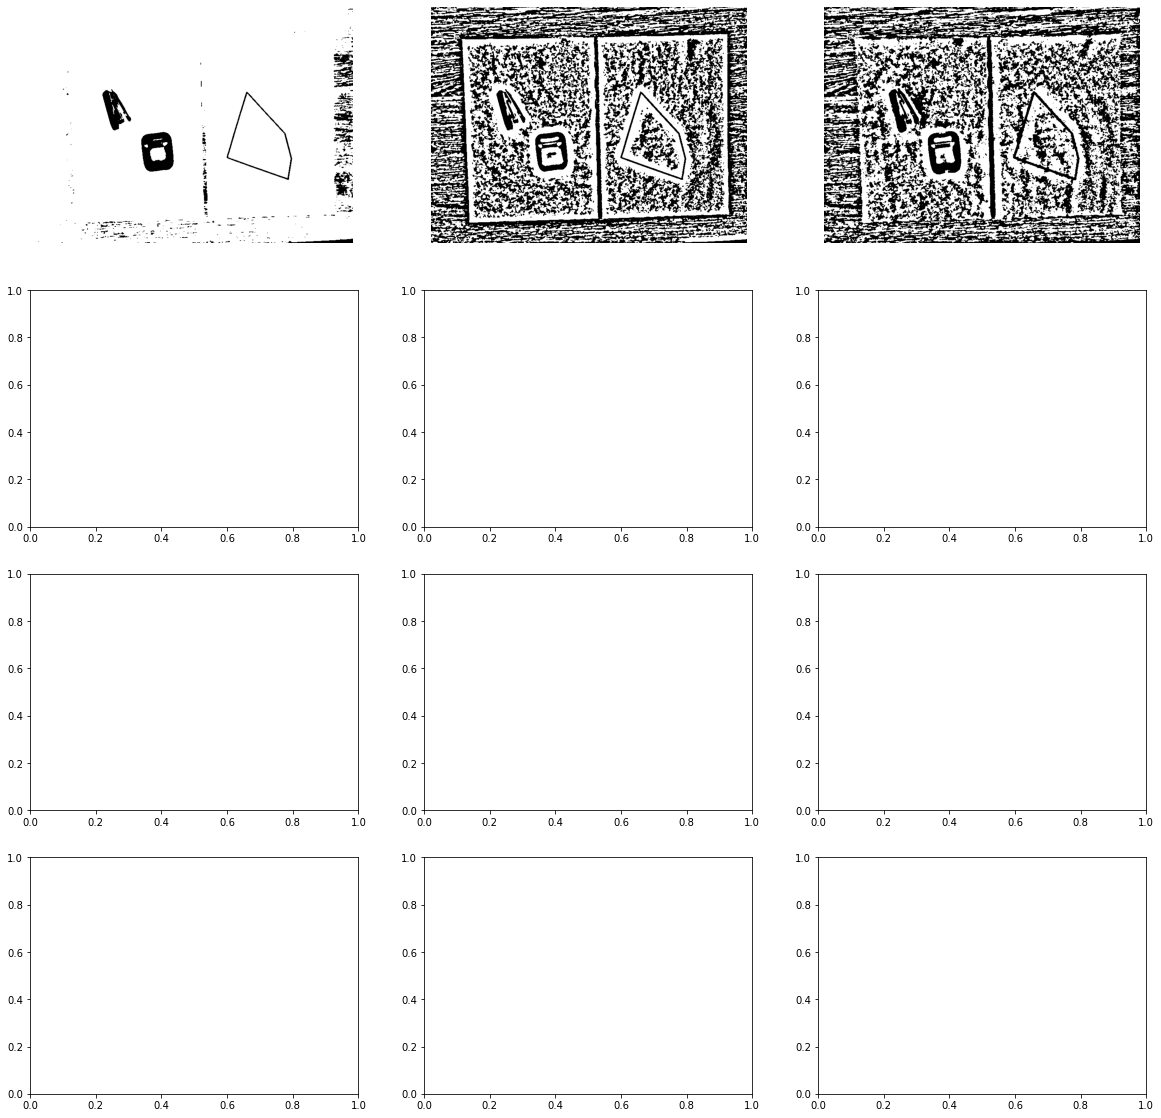

In [11]:
input_path = os.path.join('input\\tests', '03True.jpeg')
input_img = imread(input_path)

compressed_input = cv2.resize(input_img, [int(input_img.shape[1] * 0.2), int(input_img.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_input = gaussian(compressed_input, sigma=1, channel_axis=2)
gray_input = rgb2gray(filtered_input)

fig, ax = plt.subplots(4, 3, figsize=(20, 20))

mean_input = gray_input >= threshold_local(gray_input, 33, method='mean')
gaussian_input = gray_input >= threshold_local(gray_input, 41, method='gaussian')
median_input = gray_input >= threshold_local(gray_input, 41, method='median')
ax[0, 0].imshow(mean_input, cmap='gray')
ax[0, 1].imshow(gaussian_input, cmap='gray')
ax[0, 2].imshow(median_input, cmap='gray')
for j in range(4):
    for i in range(3): ax[j, i].set_axis_off()

for j in range(4):
    for i, title in enumerate(["Local: Mean", "Local: Gaussian", "Local: Median"]): ax[j, i].set_title(title)
    
mean_threshold_res_enclosed_inside = binary_erosion(binary_dilation(mean_input))
mean_threshold_res_enclosed = binary_opening(mean_threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
ax[1, 0].imshow(mean_threshold_res_enclosed, cmap="gray")

gaussian_threshold_res_enclosed_inside = binary_erosion(binary_dilation(gaussian_input))
gaussian_threshold_res_enclosed = binary_opening(gaussian_threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
ax[1, 1].imshow(gaussian_threshold_res_enclosed, cmap="gray")

median_threshold_res_enclosed_inside = binary_erosion(binary_dilation(median_input))
median_threshold_res_enclosed = binary_opening(median_threshold_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1, 2].imshow(median_threshold_res_enclosed, cmap="gray")

# Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
mean_component_of_left_sheet = get_largest_component_by_num(mean_threshold_res_enclosed, 0)
ax[2, 1].imshow(mean_component_of_left_sheet, cmap="gray")
gaussian_component_of_left_sheet = get_largest_component_by_num(gaussian_threshold_res_enclosed, 0)
ax[2, 2].imshow(gaussian_component_of_left_sheet, cmap="gray")
median_component_of_left_sheet = get_largest_component_by_num(median_threshold_res_enclosed, 0)
ax[2, 3].imshow(median_component_of_left_sheet, cmap="gray")

mean_component_of_right_sheet = get_largest_component_by_num(mean_threshold_res_enclosed, 1)
ax[3, 1].imshow(mean_component_of_right_sheet, cmap="gray")

gaussian_component_of_right_sheet = get_largest_component_by_num(gaussian_threshold_res_enclosed, 1)
ax[3, 2].imshow(gaussian_component_of_right_sheet, cmap="gray")

median_component_of_right_sheet = get_largest_component_by_num(median_threshold_res_enclosed, 1)
ax[3, 3].imshow(median_component_of_right_sheet, cmap="gray")

first_sheet_mask = 1 - get_largest_component(1 - mean_component_of_first_sheet)
second_sheet_mask = 1 - get_largest_component(1 - mean_component_of_second_sheet)

ax[2, 0].imshow(left_sheet_mask, cmap="gray")
ax[3, 0].imshow(right_sheet_mask, cmap="gray")


## С помощью бинаризации получим изображение левой и правой частей исходного изображения

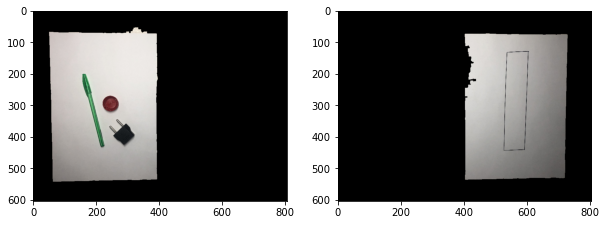

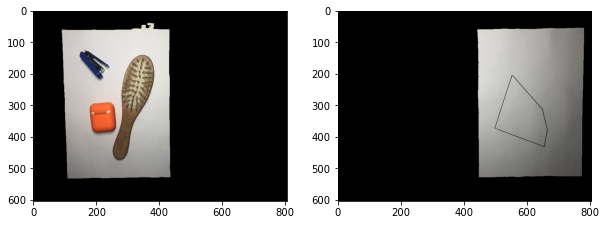

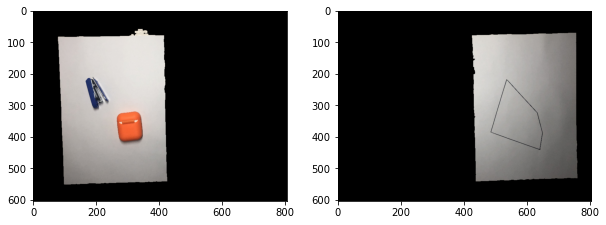

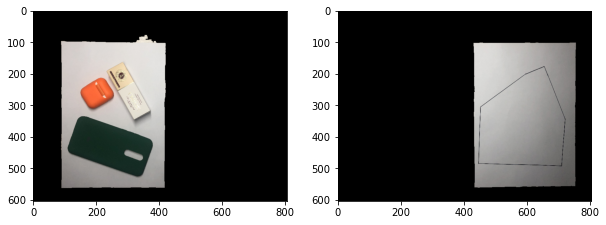

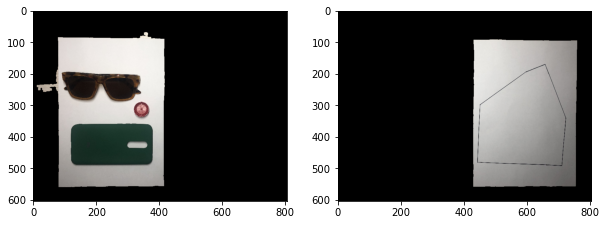

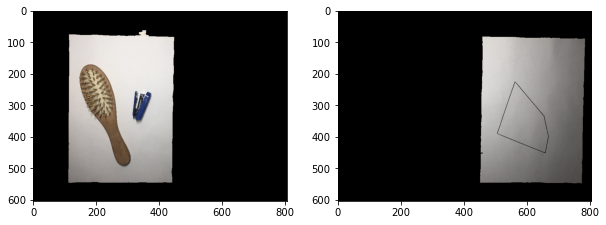

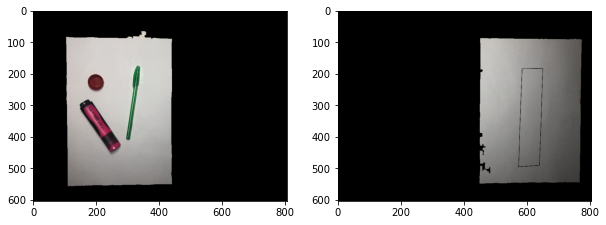

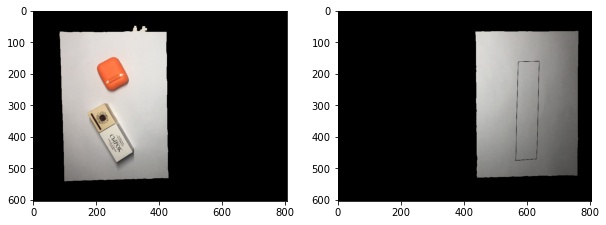

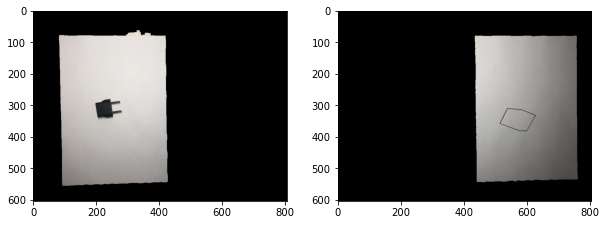

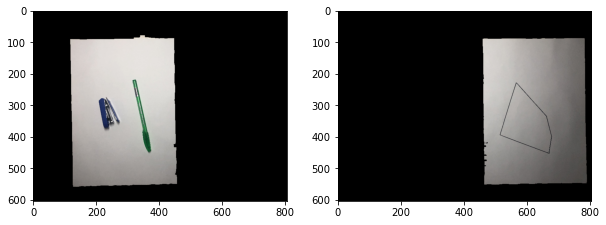

In [8]:
names = ['01True.jpeg', '02False.jpeg', '03True.jpeg', '04True.jpeg', '05True.jpeg', '06False.jpeg', '07True.jpeg', '08False.jpeg',
 '09True.jpeg', '10True.jpeg']
for name in names:
    input_path = os.path.join('input\\tests', name)
    input_img = imread(input_path)
    
    compressed_input = cv2.resize(input_img, [int(input_img.shape[1] * 0.2), int(input_img.shape[0] * 0.2)], cv2.INTER_AREA)
    filtered_input = gaussian(compressed_input, sigma=1, channel_axis=2)
    gray_input = rgb2gray(filtered_input)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    mean_input = gray_input >= threshold_local(gray_input, 63, method='mean')
    
    threshold_res_enclosed_inside = binary_erosion(binary_dilation(mean_input))
    threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
    
    # Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
    component_of_first_sheet = get_largest_component_by_num(threshold_res_enclosed, 0)
    
    component_of_second_sheet = get_largest_component_by_num(threshold_res_enclosed, 1)
    
    first_sheet_mask = 1 - get_largest_component(1 - component_of_first_sheet)
    second_sheet_mask = 1 - get_largest_component(1 - component_of_second_sheet)
    
    first_sheet_mask = first_sheet_mask.astype("uint8")
    second_sheet_mask = second_sheet_mask.astype("uint8")
    ax[0].imshow(cv2.bitwise_and(compressed_input,compressed_input,mask = first_sheet_mask), cmap="gray")
    ax[1].imshow(cv2.bitwise_and(compressed_input,compressed_input,mask = second_sheet_mask), cmap="gray")

In [6]:
def get_crop_coord(mask):
    labels = sk_measure_label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    points = [prop.coords for prop in props]
    
    x_coords = [point[1] for point in points[0]] # у нас всего одна компонента связности
    y_coords = [point[0] for point in points[0]]
    left_coord, right_coord = min(x_coords), max(x_coords)
    upper_coord, lower_coord = min(y_coords), max(y_coords)
    return ((left_coord, upper_coord), (right_coord, lower_coord))

[306454, 7653, 3359, 48, 201, 44, 6, 6, 11, 5, 4529, 80, 9548, 60, 74, 57, 22, 24, 29, 65, 3659, 5, 107, 4525, 2561, 1151, 12, 6, 23, 71, 769, 11561, 27, 8, 11, 5, 794, 1836, 6, 53, 19, 42, 21, 6]
[320170, 26791, 92, 89, 45, 767, 36, 38868, 10, 68, 16, 5, 69, 326, 9, 12798, 14, 5, 7, 71]
((60, 33), (432, 546))
((435, 31), (797, 530))
15True.jpeg


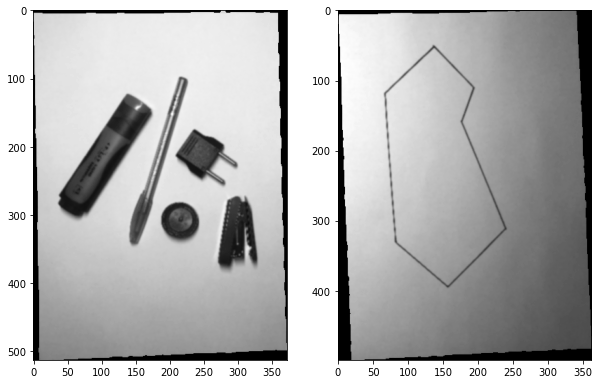

In [7]:
input_path = os.path.join('input\\tests', '15True.jpeg')
input_img = imread(input_path)
compressed_input = cv2.resize(input_img, [int(input_img.shape[1] * 0.2), int(input_img.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_input = gaussian(compressed_input, sigma=1, channel_axis=2)
gray_input = rgb2gray(filtered_input)
    
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
mean_input = gray_input >= threshold_local(gray_input, 63, method='mean') #63
# ax[0, 0].imshow(mean_input, cmap='gray')
    
mean_threshold_res_enclosed_inside = binary_erosion(binary_dilation(mean_input))
mean_threshold_res_enclosed = binary_opening(mean_threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
# ax[0, 1].imshow(mean_threshold_res_enclosed, cmap="gray")
    
    # Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
mean_component_of_left_sheet = get_largest_component_by_num(mean_threshold_res_enclosed, 0)
# ax[0, 2].imshow(mean_component_of_left_sheet, cmap="gray")
    
mean_component_of_right_sheet = get_largest_component_by_num(mean_threshold_res_enclosed, 1)
# ax[0, 3].imshow(mean_component_of_right_sheet, cmap="gray")
    
left_sheet_mask = 1 - get_largest_component(1 - mean_component_of_left_sheet)
right_sheet_mask = 1 - get_largest_component(1 - mean_component_of_right_sheet)

# ax[1, 0].imshow(left_sheet_mask, cmap="gray")
# ax[1, 1].imshow(right_sheet_mask, cmap="gray")
    
left_sheet_mask = left_sheet_mask.astype("uint8")
left_rectangle_coords = get_crop_coord(left_sheet_mask)
print(left_rectangle_coords)

right_sheet_mask = right_sheet_mask.astype("uint8")
right_rectangle_coords = get_crop_coord(right_sheet_mask)
print(right_rectangle_coords)

left_sheet = cv2.bitwise_and(gray_input,gray_input,mask = left_sheet_mask)
right_sheet = cv2.bitwise_and(gray_input,gray_input,mask = right_sheet_mask)

sheets_list = [left_sheet[left_rectangle_coords[0][1]:left_rectangle_coords[1][1], left_rectangle_coords[0][0]:left_rectangle_coords[1][0]],
               right_sheet[right_rectangle_coords[0][1]:right_rectangle_coords[1][1],right_rectangle_coords[0][0]:right_rectangle_coords[1][0]]]
cropped_input_list = [compressed_input[left_rectangle_coords[0][1]:left_rectangle_coords[1][1], left_rectangle_coords[0][0]:left_rectangle_coords[1][0]],
                                  compressed_input[right_rectangle_coords[0][1]:right_rectangle_coords[1][1],right_rectangle_coords[0][0]:right_rectangle_coords[1][0]]]

ax[0].imshow(sheets_list[0], cmap="gray")
ax[1].imshow(sheets_list[1], cmap="gray")

# Сохранение полученного изображения в файл
name = input_path[input_path.rfind("\\") + 1:]
print(name)
sheets = os.path.join("results", name)
# plt.savefig(sheets)

0.6216422735320626 0.296560788511681
0.46845922335842743 0.2058627748032714


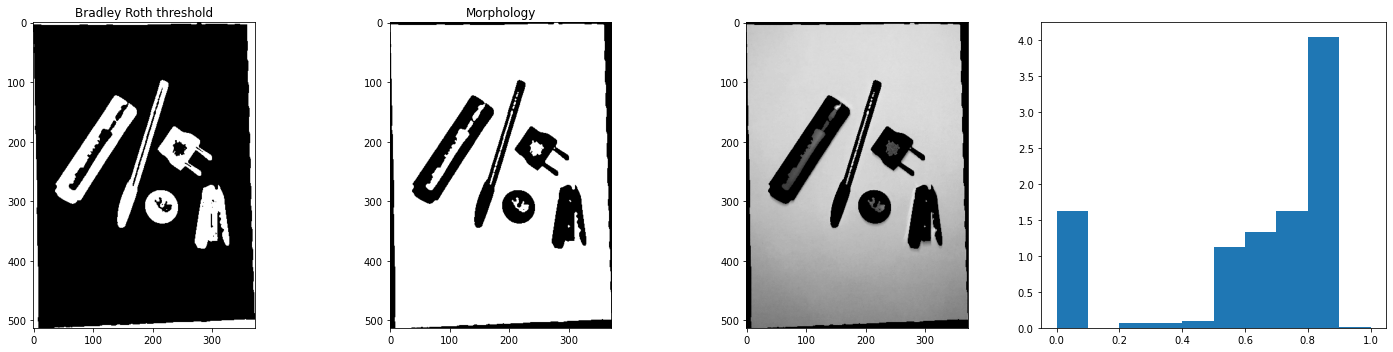

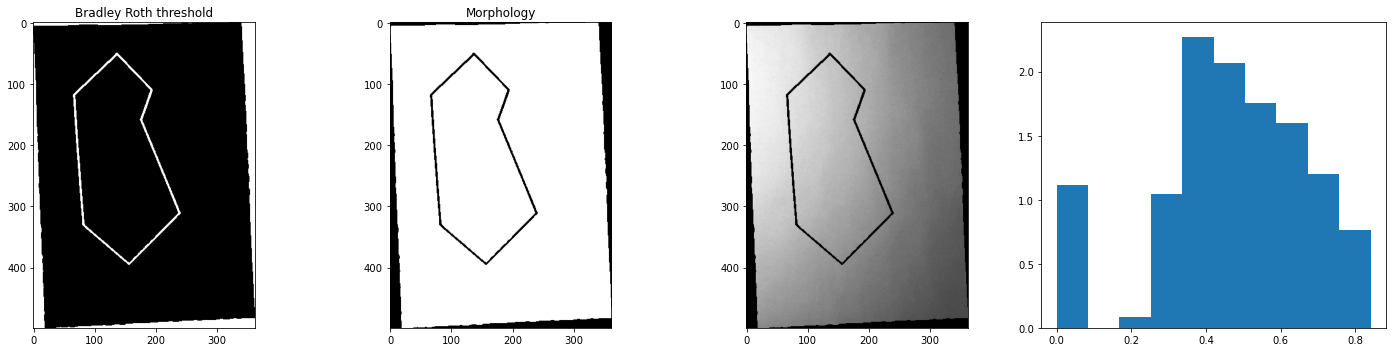

In [8]:
for sheet, cropped_input in zip(sheets_list, cropped_input_list):
    std = np.array([])
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#     filtered_sheet = gaussian(sheet, sigma=1, channel_axis=2)
#     gray_sheet = rgb2gray(sheet)
    
        
    # Используем алгоритм определения порога Брэдли-Рота
    bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(sheet))
    ax[0].imshow(bradley_roth_res, cmap='gray')

    bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
    bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((1, 1)))
    ax[1].imshow(1 - bradley_roth_res_enclosed, cmap='gray')
    
    input_mask = (1 - bradley_roth_res_enclosed).astype("uint8")
    input_by_mask = rgb2gray(cv2.bitwise_and(cropped_input,cropped_input,mask = input_mask))

    std = np.append(std, np.std(input_by_mask.flatten()))
#     print(np.mean(input_by_mask.flatten()), np.std(input_by_mask.flatten()))
    ax[2].imshow(input_by_mask, cmap='gray')
#     ax[3].hist(input_by_mask.ravel(), density=True)

    for i, title in enumerate(["Bradley Roth threshold", "Morphology"]):
        ax[i].set_title(title)
    
    fig.tight_layout()


0.6926436734321731 0.269817149012465
0.5901354695743329 0.2019950297548007
0.5873388161647457 0.32029946943476273
0.5667085781118184 0.18981983829001894
0.6534034914670578 0.2790508062752554
0.5573355463136189 0.19975500392920925
0.5577117179825213 0.33914099342861515
0.6024172984326622 0.17885169205424692
0.45507277421105036 0.40729781675567744
0.6483828204226098 0.18479366183830037
0.6537529411424694 0.3079851383133669
0.5457517553149964 0.19535886402243424
0.6305124429721954 0.26433375897536193
0.48310479935436873 0.17827281468189912
0.6685051440970142 0.2808783630261271
0.5593462952299073 0.18291369294211404
0.71152223634399 0.24242551505891824
0.5590262560292903 0.17749493949745834
0.6860656055683146 0.2484946767371649
0.5286536252620424 0.18366709272213852
0.5744072438327456 0.35294822289769173
0.5269139013022353 0.2219090761847169
0.7139931084284262 0.2129276792878664
0.5447858112485613 0.19237073967038792
0.7067716166492621 0.3056525777082917
0.5684683538009845 0.19980872508269

C:\Temp\ipykernel_5292\3860294578.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2, 1, figsize=(10, 10))


0.6807466061111064 0.2548538281221907
0.49234038401309005 0.19172744070728942
0.7080845909664731 0.238757554807325
0.5025582419919882 0.19974432658168365
0.7434959373223736 0.22671914833690354
0.5346396811586451 0.1745821877871113
0.7065031831018728 0.26639801478772424
0.5122860070507836 0.18184261842645483
0.7132976692739641 0.20209374790342471
0.5725402127076706 0.19539904786557177


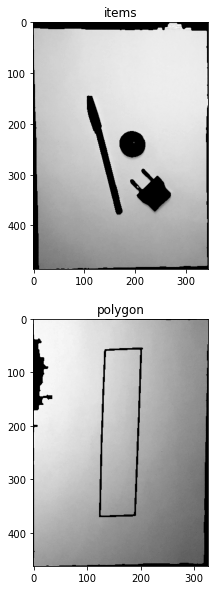

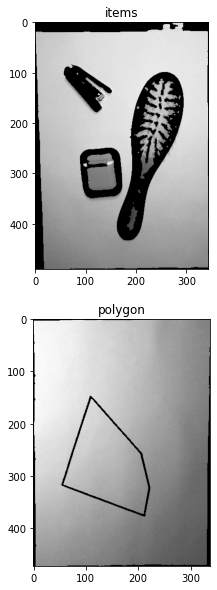

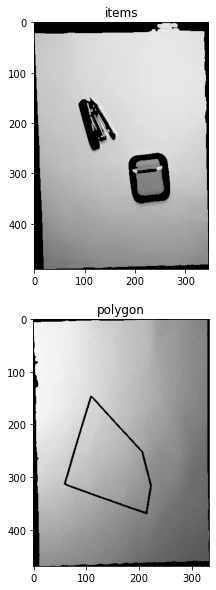

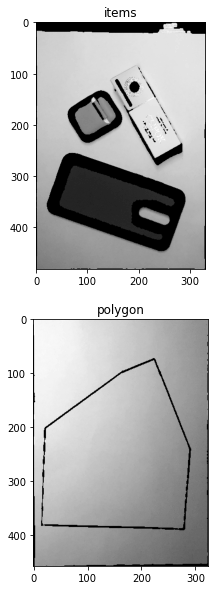

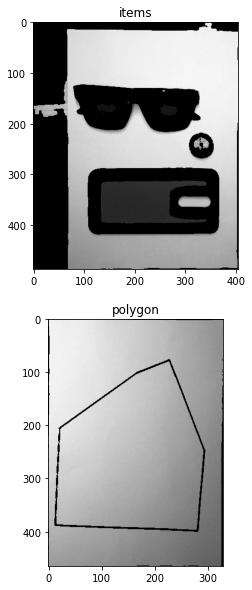

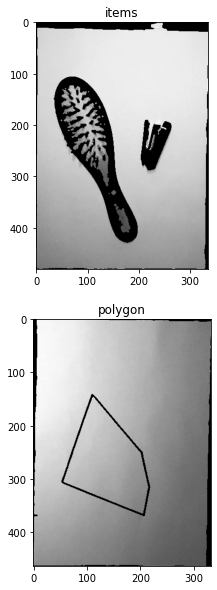

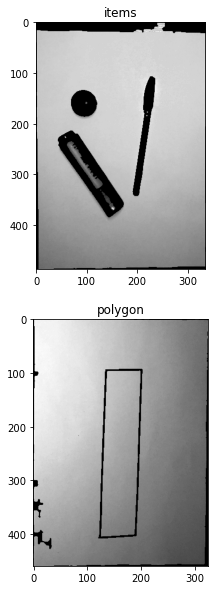

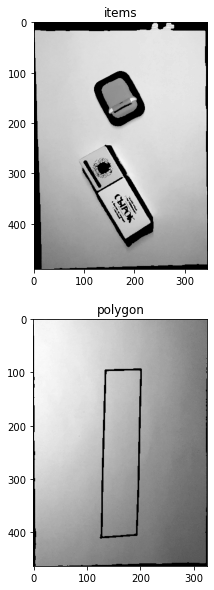

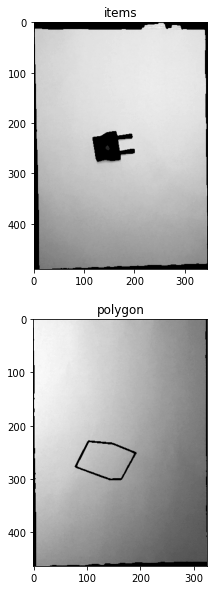

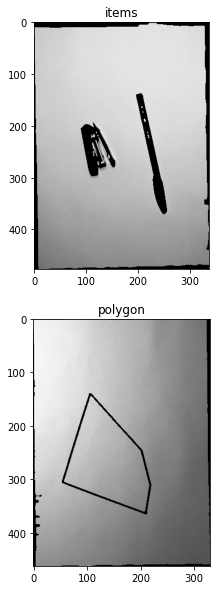

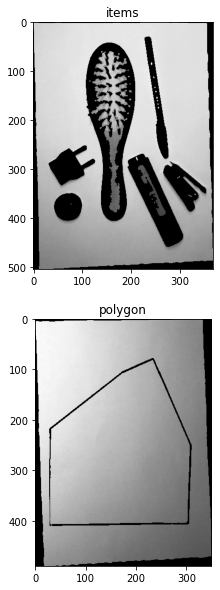

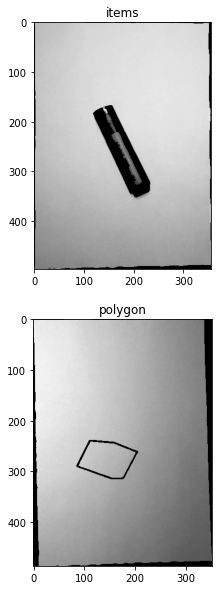

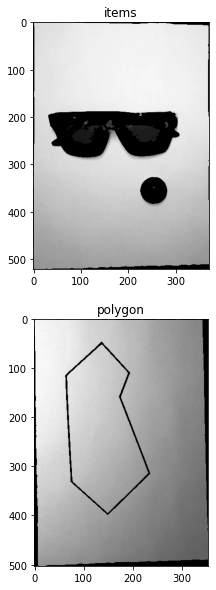

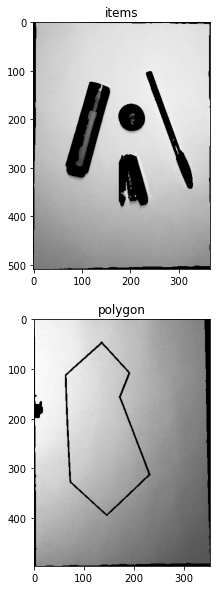

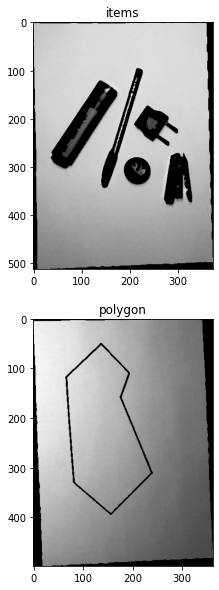

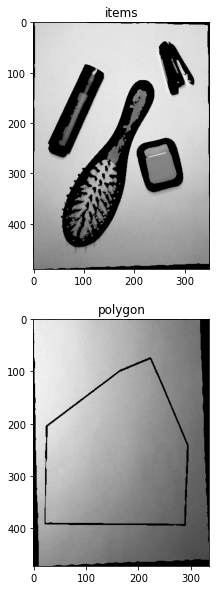

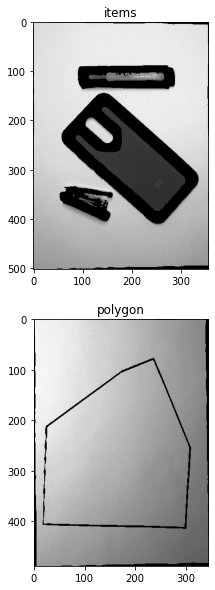

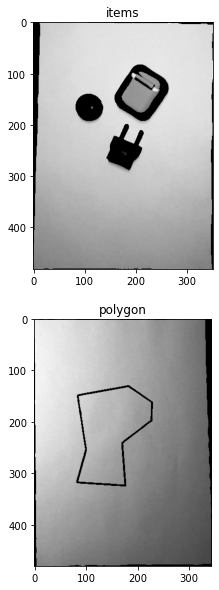

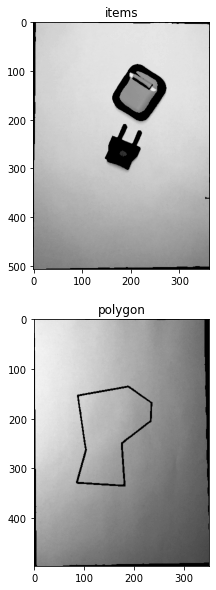

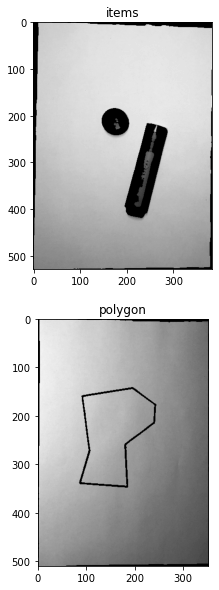

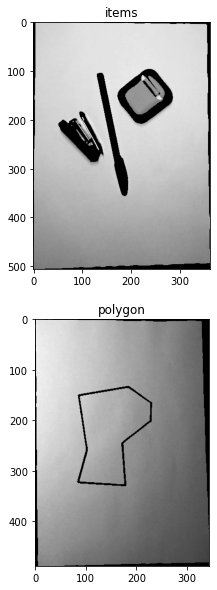

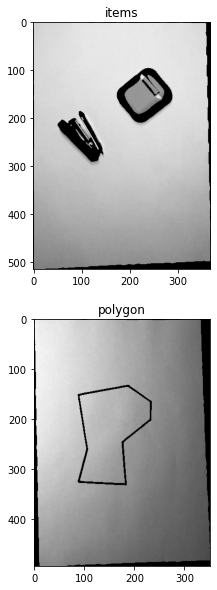

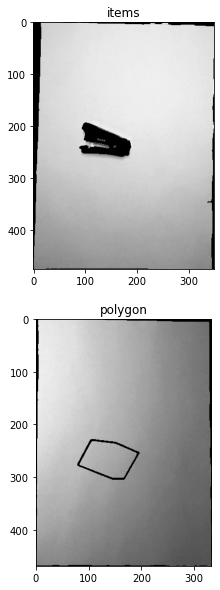

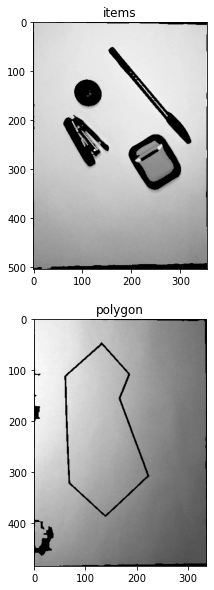

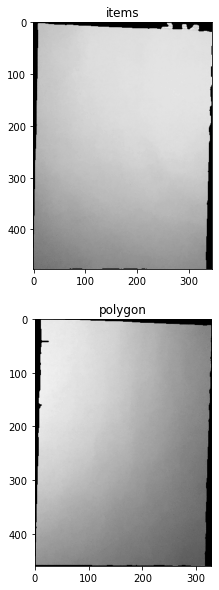

In [23]:
for name in os.listdir('input\\tests'):
    std = np.array([])
    input_path = os.path.join('input\\tests', name)
    input_img = imread(input_path)
    compressed_input = cv2.resize(input_img, [int(input_img.shape[1] * 0.2), int(input_img.shape[0] * 0.2)], cv2.INTER_AREA)
    filtered_input = gaussian(compressed_input, sigma=1, channel_axis=2)
    gray_input = rgb2gray(filtered_input)
    
#     fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    mean_input = gray_input >= threshold_local(gray_input, 63, method='mean') #63

    mean_threshold_res_enclosed_inside = binary_erosion(binary_dilation(mean_input))
    mean_threshold_res_enclosed = binary_opening(mean_threshold_res_enclosed_inside, footprint=np.ones((7, 7)))

    # Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
    mean_component_of_left_sheet = get_largest_component_by_num(mean_threshold_res_enclosed, 0)

    mean_component_of_right_sheet = get_largest_component_by_num(mean_threshold_res_enclosed, 1)

    left_sheet_mask = 1 - get_largest_component(1 - mean_component_of_left_sheet)
    right_sheet_mask = 1 - get_largest_component(1 - mean_component_of_right_sheet)

    left_sheet_mask = left_sheet_mask.astype("uint8")
    left_rectangle_coords = get_crop_coord(left_sheet_mask)

    right_sheet_mask = right_sheet_mask.astype("uint8")
    right_rectangle_coords = get_crop_coord(right_sheet_mask)

    left_sheet = cv2.bitwise_and(gray_input,gray_input,mask = left_sheet_mask)
    right_sheet = cv2.bitwise_and(gray_input,gray_input,mask = right_sheet_mask)

    sheets_list = [left_sheet[left_rectangle_coords[0][1]:left_rectangle_coords[1][1], left_rectangle_coords[0][0]:left_rectangle_coords[1][0]],
                   right_sheet[right_rectangle_coords[0][1]:right_rectangle_coords[1][1],right_rectangle_coords[0][0]:right_rectangle_coords[1][0]]]
    cropped_input_list = [compressed_input[left_rectangle_coords[0][1]:left_rectangle_coords[1][1], left_rectangle_coords[0][0]:left_rectangle_coords[1][0]],
                                      compressed_input[right_rectangle_coords[0][1]:right_rectangle_coords[1][1],right_rectangle_coords[0][0]:right_rectangle_coords[1][0]]]

#     ax[0].imshow(sheets_list[0], cmap="gray")
#     ax[1].imshow(sheets_list[1], cmap="gray")
    
#     # Сохранение полученного изображения в файл
    name = input_path[input_path.rfind("\\") + 1:]
#     print(name)
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))    
    for i in range(2):
        # Используем алгоритм определения порога Брэдли-Рота
        bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(sheets_list[i]))
#         ax[0].imshow(bradley_roth_res, cmap='gray')

        bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
        bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((1, 1)))
#         ax[1].imshow(1 - bradley_roth_res_enclosed, cmap='gray')

        input_mask = (1 - bradley_roth_res_enclosed).astype("uint8")
        input_by_mask = rgb2gray(cv2.bitwise_and(cropped_input_list[i],cropped_input_list[i],mask = input_mask))
        std = np.append(std, np.std(input_by_mask.flatten()))
        print(np.mean(input_by_mask.flatten()), np.std(input_by_mask.flatten()))
        ax[i].imshow(input_by_mask, cmap='gray')

    
    if (std[0] > std[1]):
        ax[0].set_title("items")
        ax[1].set_title("polygon")
    else:
        ax[0].set_title("polygon")
        ax[1].set_title("items")            

#         print(np.mean(input_by_mask.flatten()), np.std(input_by_mask.flatten()))

#         ax[2].imshow(input_by_mask, cmap='gray')
#         ax[3].hist(input_by_mask.ravel(), density=True)

#         for i, title in enumerate(["Bradley Roth threshold", "Morphology"]):
#             ax[i].set_title(title)

#         fig.tight_layout()
        
#         sheets = os.path.join("results\\cropped", name)
#         plt.savefig(sheets)


In [7]:
os.listdir('input\\tests')


['01True.jpeg',
 '02False.jpeg',
 '03True.jpeg',
 '04True.jpeg',
 '05True.jpeg',
 '06False.jpeg',
 '07True.jpeg',
 '08False.jpeg',
 '09True.jpeg',
 '10True.jpeg',
 '11True.jpeg',
 '12False.jpeg',
 '13True.jpeg',
 '14True.jpeg',
 '15True.jpeg',
 '16True.jpeg',
 '17True.jpeg',
 '18True.jpeg',
 '19True.jpeg',
 '20True.jpeg',
 '21False.jpeg',
 '22True.jpeg',
 '23False.jpeg',
 '24True.jpeg',
 'background.jpeg']